# L2 – Multilayer perceptron

### PyTorch
1. [Installing PyTorch](https://pytorch.org/get-started/locally/)
2. [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
3. [Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
4. [Useful examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
5. [Mnist example](https://habr.com/company/otus/blog/358096/)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset.
4. Chek accuracy on train and validation sets (visualize resulted graph).

$$\frac{dQ}{dW} = (\frac{dQ}{dW_1}, ... , \frac{dQ}{dW_{|c|}})$$
## Let's start with a partial derivative

$$ \frac{dQ}{dw_i} = -{1 \over l} \sum\limits_y \sum\limits_k [y = k] \cdot \left(\ln\frac{e^{w_k^Tx}}{\sum\limits_j e^{w_j^Tx}}\right)'_{w_i} = -{1 \over l} \sum\limits_y \sum\limits_k [y = k] \cdot \left([k = i]\ln\frac{e^{w_kx}}{\sum\limits_j e^{w_j^Tx}} + [k \neq i]\ln\frac{e^{w_k^Tx}}{\sum\limits_j e^{w_jx}}\right)'_{w_i} = $$ $$ = -{1 \over l} \sum\limits_y \sum\limits_k [y = k] \cdot \left([k = i] \cdot \frac{x\sum\limits_j [i \neq j] e^{w_j^Tx}}{\sum\limits_j e^{w_j^Tx}} - \frac{xe^{w_i^Tx}}{\sum\limits_j e^{w_j^Tx}}\right) = $$ $$ = -{1\over l} \sum\limits_y \sum\limits_k [y = k] \cdot \left([k = i] \cdot x - \frac{xe^{w_i^Tx}}{\sum\limits_j e^{w_j^Tx}}\right) = $$ $$ = -{x\over l} \sum\limits_y \left([y = i] - \frac{e^{w_i^Tx}}{\sum\limits_j e^{w_j^Tx}}\right) $$

## These are the columns of matrix $\frac{dQ}{dW}$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline

In [2]:
#importing mnist
import mnist
mnist.temporary_dir = lambda: '/home/igor' #path
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [3]:
#hyperparameters
epochs = 15
batch_size = 100
test_batch_size = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

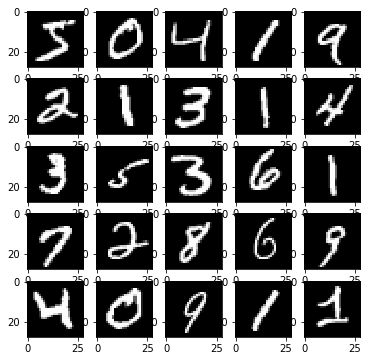

In [4]:
#plotting mnist
fig = plt.figure(figsize=(6, 6))
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
plt.show()

In [5]:
#our simple net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [6]:
#creating loader for torch
#we can also import mnist via torchvision.datasets
train = utils.data.TensorDataset(torch.as_tensor(train_images).float(), torch.as_tensor(train_labels).long())
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True)
test = torch.utils.data.TensorDataset(torch.as_tensor(test_images).float(), torch.as_tensor(test_labels).long())
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=test_batch_size,
                shuffle=False)

In [7]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
#train function
def train(epoch):
    for batch_num, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_num % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_num * len(data), len(train_loader.dataset),
                100. * batch_num / len(train_loader), loss.data.item()))
    else:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_num * len(data), len(train_loader.dataset),
            100. * batch_num / len(train_loader), loss.data.item()))

In [9]:
#test function
def test(log=None):
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).data.item()
            pred = output.data.max(1, keepdim=True)[1]
            test_correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_correct_percent = 100. * test_correct / len(test_loader.dataset)

        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            output = model(data)
            train_loss += F.cross_entropy(output, target, size_average=False).data.item()
            pred = output.data.max(1, keepdim=True)[1]
            train_correct += pred.eq(target.data.view_as(pred)).sum()
        train_loss /= len(train_loader.dataset)
        train_correct_percent = 100. * train_correct / len(train_loader.dataset)
    
    print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, test_correct, len(test_loader.dataset), test_correct_percent))
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset), train_correct_percent))
    
    log['test'].append((test_loss, test_correct_percent))
    log['train'].append((train_loss, train_correct_percent))

In [10]:
err_log = {'test': [], 'train': []}

In [11]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(err_log)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291203
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.677558
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.684321
Train Epoch: 1 [59900/60000 (100%)]	Loss: 1.810299


/home/igor/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set:  Average loss: 1.7240, Accuracy: 7367/10000 (73%)
Train set: Average loss: 1.7300, Accuracy: 43842/60000 (73%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.715827
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.687729
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.692335
Train Epoch: 2 [59900/60000 (100%)]	Loss: 1.751957

Test set:  Average loss: 1.7111, Accuracy: 7494/10000 (74%)
Train set: Average loss: 1.7122, Accuracy: 44888/60000 (74%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.735329
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.739951
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.753146
Train Epoch: 3 [59900/60000 (100%)]	Loss: 1.709635

Test set:  Average loss: 1.7068, Accuracy: 7539/10000 (75%)
Train set: Average loss: 1.7058, Accuracy: 45280/60000 (75%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.699169
Train Epoch: 4 [20000/60000 (33%)]	Loss: 1.561922
Train Epoch: 4 [40000/60000 (67%)]	Loss: 1.699700
Train Epoch: 4 [59900/60000 (100%)]	Loss: 1.737687

Test set:  Average loss: 1.7024, Accuracy:

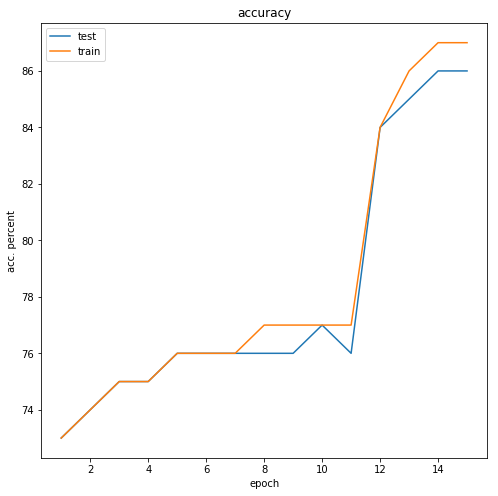

In [12]:
plt.figure(figsize=(8, 8))
keys = err_log.keys()
epochs = range(1, epochs + 1)
logs = {k:[z for z in zip(*err_log[k])] for k in keys}
h, = zip(*[plt.plot(epochs, logs[k][1], label=k) for k in keys])
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('acc. percent')
plt.legend(handles=h)
plt.show()

Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

In [13]:
def reg_train(epoch):
    for batch_num, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        L1 = torch.norm(model.fc1.weight.data, 1) + torch.norm(model.fc2.weight.data, 1)
        L2 = torch.norm(model.fc1.weight.data ** 2, 2) + torch.norm(model.fc2.weight.data ** 2, 2)
        l1, l2 = 0.5, 0.5
        loss += l1 * L1 + l2 * L2
        loss.backward()
        optimizer.step()
        if batch_num % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_num * len(data), len(train_loader.dataset),
                100. * batch_num / len(train_loader), loss.data.item()))
    else:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_num * len(data), len(train_loader.dataset),
            100. * batch_num / len(train_loader), loss.data.item()))

In [14]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)
reglog = {'test': [], 'train': []}

epochs = 20
for epoch in range(1, epochs + 1):
    train(epoch)
    test(err_log)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.429813
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.732966
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.685448
Train Epoch: 1 [59900/60000 (100%)]	Loss: 1.672876

Test set:  Average loss: 1.6370, Accuracy: 8241/10000 (82%)
Train set: Average loss: 1.6363, Accuracy: 49461/60000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.650560
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.609211
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.621682
Train Epoch: 2 [59900/60000 (100%)]	Loss: 1.525663

Test set:  Average loss: 1.5424, Accuracy: 9178/10000 (91%)
Train set: Average loss: 1.5475, Accuracy: 54801/60000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.600937
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.590649
Train Epoch: 3 [40000/60000 (67%)]	Loss: 1.587614
Train Epoch: 3 [59900/60000 (100%)]	Loss: 1.544481

Test set:  Average loss: 1.5314, Accuracy: 9298/10000 (92%)
Train set: Average loss: 1.5314, Accuracy: 55777/60000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.55163

/home/igor/anaconda3/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


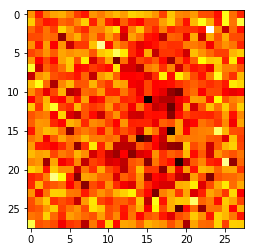

In [15]:
res = torch.sum(model.fc1.weight.data, 0)
res = res.resize(28, 28)
plt.imshow(res, cmap='hot')
plt.show()

## Pixels, which are located closer to borders, have less impact (because digits are located in the middle of the picture), thus weights applied to these pixels are closer to zero.

## Moreover, regularization increased accuracy from ~87% to ~97% (but also 2x more epochs have influence here)

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

Given $w = (w_1, w_2)$ and $x = (x_1, x_2)^T$. Let $b$ be equal to $-1$, and $(w_1, w_2) = (1.5, 1.5)$
So, $$y(0, 0) = \sigma(1.5\cdot0 + 1.5\cdot0 - 1) = 0$$ $$y(0, 1) = \sigma(1.5\cdot0 + 1.5\cdot1 - 1) = 1 $$ $$y(1, 0) = \sigma(1.5\cdot1 + 1.5\cdot0 - 1) = 1 $$ $$ y(1, 1) = \sigma(1.5\cdot1 + 1.5\cdot1 - 1) = 1 $$
That's nothing else than **OR**.

**__________________________________________________________________________________**

For now, let $b$ be equal to $-1.5$, and $(w_1, w_2) = (1, 1)$......checking.... This exactly implements **AND**.

**__________________________________________________________________________________**

For $x = (0, 0)$ or $x = (1, 1)$ we have result $0$, so, $b > 0$ and $b > w_1 + w_2$. But for $x = (0, 1)$ and for $x = (1, 0)$ we have result $1$, so $b < w_1$ and $b < w_2$ at the same time. Given that, $b$ can't be bigger than $w_1 + w_2$. And that's why **XOR** could not be implemented this way.

**__________________________________________________________________________________**

We can implement Sheffer stroke, which is a boolean basis, with first layer, and then we can implement any boolean function using this with second layer.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [16]:
class SigmoidNet(nn.Module):
    def __init__(self):
        super(SigmoidNet, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [17]:
model = SigmoidNet()
optimizer = optim.SGD(model.parameters(), lr=0.01)
log = {'test': [], 'train': []}

epoch = 20
for epoch in range(epochs):
    train(epoch)
    test(log)

print('\nTest set:  Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
    log['test'][-1][0], log['test'][-1][1]))

print('Train set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
    log['train'][-1][0], log['train'][-1][1]))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.370212
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.972934
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.581620
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.455561

Test set:  Average loss: 0.5099, Accuracy: 8987/10000 (89%)
Train set: Average loss: 0.5191, Accuracy: 53663/60000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.423436
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.541603
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.412497
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.396768

Test set:  Average loss: 0.3708, Accuracy: 9164/10000 (91%)
Train set: Average loss: 0.3750, Accuracy: 54863/60000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.483315
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.489752
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.303694
Train Epoch: 2 [59900/60000 (100%)]	Loss: 0.321690

Test set:  Average loss: 0.3187, Accuracy: 9207/10000 (92%)
Train set: Average loss: 0.3195, Accuracy: 55295/60000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.36092

In [18]:
class TripleNet(nn.Module):
    def __init__(self):
        super(TripleNet, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.log_softmax(x, dim=1)
        return x

In [19]:
model = TripleNet()
optimizer = optim.Adam(model.parameters(), lr=0.01) #here we finally switch from sgd to adam
log = {'test': [], 'train': []}

epochs = 20
for epoch in range(epochs):
    train(epoch)
    test(log)

print('\nTest set:  Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
    log['test'][-1][0], log['test'][-1][1]))

print('Train set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
    log['train'][-1][0], log['train'][-1][1]))

Train Epoch: 0 [0/60000 (0%)]	Loss: 9.462654
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.617582
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.261049
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.161277

Test set:  Average loss: 0.2081, Accuracy: 9396/10000 (93%)
Train set: Average loss: 0.2081, Accuracy: 56330/60000 (93%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.101876
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.175831
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.732110
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.200896

Test set:  Average loss: 0.1656, Accuracy: 9503/10000 (95%)
Train set: Average loss: 0.1565, Accuracy: 57244/60000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.204728
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.211610
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.134315
Train Epoch: 2 [59900/60000 (100%)]	Loss: 0.081757

Test set:  Average loss: 0.1466, Accuracy: 9593/10000 (95%)
Train set: Average loss: 0.1131, Accuracy: 57925/60000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.14271

In [20]:
#let's try regularization
model = TripleNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
log = {'test': [], 'train': []}

epochs = 20
for epoch in range(epochs):
    train(epoch)
    test(log)

print('\nTest set:  Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
    log['test'][-1][0], log['test'][-1][1]))

print('Train set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
    log['train'][-1][0], log['train'][-1][1]))

Train Epoch: 0 [0/60000 (0%)]	Loss: 8.364315
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.379552
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.272665
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.229220

Test set:  Average loss: 0.2478, Accuracy: 9287/10000 (92%)
Train set: Average loss: 0.2452, Accuracy: 55886/60000 (93%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.181558
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.402612
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.443136
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.317431

Test set:  Average loss: 0.2200, Accuracy: 9403/10000 (94%)
Train set: Average loss: 0.2006, Accuracy: 56575/60000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.332789
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.020541
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.173054
Train Epoch: 2 [59900/60000 (100%)]	Loss: 0.187751

Test set:  Average loss: 0.1954, Accuracy: 9438/10000 (94%)
Train set: Average loss: 0.1608, Accuracy: 57112/60000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.13900

In [21]:
#and 7 layers
class SevenNet(nn.Module):
    def __init__(self):
        super(SevenNet, self).__init__()
        self.fc1 = nn.Linear(784, 600)
        self.fc2 = nn.Linear(600, 500)
        self.fc3 = nn.Linear(500, 400)
        self.fc4 = nn.Linear(400, 300)
        self.fc5 = nn.Linear(300, 200)
        self.fc6 = nn.Linear(200, 100)
        self.fc7 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        x = F.leaky_relu(self.fc7(x))
        x = F.log_softmax(x, dim=1)
        return x

In [22]:
model = SevenNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
log = {'test': [], 'train': []}

epochs = 20
for epoch in range(epochs):
    train(epoch)
    test(log)

print('\nTest set:  Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
    log['test'][-1][0], log['test'][-1][1]))

print('Train set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
    log['train'][-1][0], log['train'][-1][1]))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.281950
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.189478
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.141873
Train Epoch: 0 [59900/60000 (100%)]	Loss: 0.149870

Test set:  Average loss: 0.1258, Accuracy: 9668/10000 (96%)
Train set: Average loss: 0.1160, Accuracy: 58124/60000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.177491
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.104804
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.283787
Train Epoch: 1 [59900/60000 (100%)]	Loss: 0.152590

Test set:  Average loss: 0.1011, Accuracy: 9732/10000 (97%)
Train set: Average loss: 0.0748, Accuracy: 58770/60000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.039733
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.044579
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.052190
Train Epoch: 2 [59900/60000 (100%)]	Loss: 0.034129

Test set:  Average loss: 0.1141, Accuracy: 9727/10000 (97%)
Train set: Average loss: 0.0723, Accuracy: 58905/60000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.09719

## 7 layers are training way longer, though they give better accuracy (or they don't and this is because of adam's LR)

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.

In [52]:
def train_ae(epoch):
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.view(-1, 28*28)
        outputs = model(data)
        loss = loss_func(outputs, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.data.item()))

In [53]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 3), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(3, 784), nn.Tanh())

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [54]:
#reloading dataset - the previous one refused to work here
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 100

dataset = MNIST('/home/igor', download = True, transform=img_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [55]:
epochs = 10
model = autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
err_log = {'test': [], 'train': []}
loss_func = nn.MSELoss(reduction='mean')
for epoch in range(epochs):
    train_ae(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 1.009079
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.527519
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.366956
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.317315
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.298024
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.287799
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.283705
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.274585
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.271327
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.260579
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.279402
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.276649
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.270644
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.271683
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.264946
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.277410
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.279603
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.270820
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.282409
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.260154
Train Epoch: 3 [2000

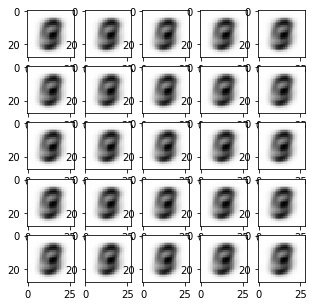

In [56]:
images, targets = next(iter(dataloader))
images = images.view(len(images), -1)
result = model(images).detach().numpy()

fig = plt.figure(figsize=(5, 5))
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.imshow(result[i].reshape(28, 28), cmap='Greys')

plt.show()

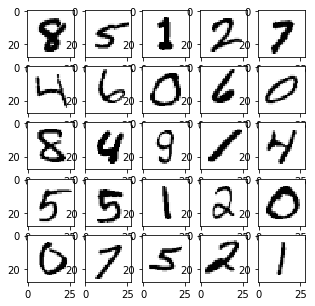

In [57]:
fig = plt.figure(figsize=(5, 5))
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap='Greys')

plt.show()

## Great, let's try 3 layers

In [58]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 300),nn.ReLU(), nn.Linear(300, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 400), nn.ReLU(), nn.Linear(400, 784), nn.Tanh())

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [59]:
epochs = 20
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
err_log = {'test': [], 'train': []}

for epoch in range(epochs):
    train_ae(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.947319
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.196786
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.183561
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.180045
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.166518
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.160303
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.162626
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.163167
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.159492
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.157438
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.160898
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.164033
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.156396
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.154542
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.157611
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.156130
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.159773
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.147725
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.145987
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.155535
Train Epoch: 3 [2000

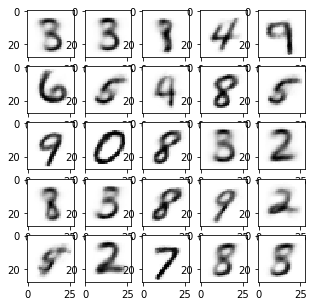

In [60]:
images, targets = next(iter(dataloader))
images = images.view(len(images), -1)
result = model(images).detach().numpy()

fig = plt.figure(figsize=(5, 5))
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.imshow(result[i].reshape(28, 28), cmap='Greys')

plt.show()

## Wow, something similar to real digits